# Load modules, …

In [2]:
%load_ext autoreload
%matplotlib inline

In [3]:
%autoreload 2

In [4]:
from __future__ import division
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as py
import plotly.graph_objs as GO

import astropy
import os

from tools import convolution, tools
from tools.readtree import readtree as rt

py.init_notebook_mode()

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 9)

ImportError: No module named _tools

In [ ]:
"""%%cython 

cimport numpy as np
import numpy as np
import itertools
from tqdm import tqdm

from cpython cimport bool"""

def load_tree(rt, halo_ids, nsteps=rt.nsteps):
    '''Build the tree for halo_id, then closes the rt descriptor using a reversed tree.
    Arguments:
    ----------
    rt: a readtree instance
    halo_ids: list-like of halos to build tree of
    nsteps: number of steps in the simulation
    
    Returns:
    --------
    halos: dict, containing for each step a dictionary of the halos, parents of the initial halo_ids
    '''
    halos = {step+1: {} for step in range(nsteps)}
    
    stop_now = False
    prev_step = nsteps+1
    
    progress = tqdm(total=nsteps)
    new_halo_ids = set(halo_ids)
    halo_ids = set(halo_ids)
    
    counter = 1
    while True:
        counter += 1
        ( stop_now, halo_id, bushid, step, level,
         hosthalo, hostsub, nbsub, nextsub,
         nb_of_fathers, nb_of_sons,
         m, macc,
         px, py, pz,
         vx, vy, vz,
         lx, ly, lz,
         r, ra, rb, rc,
         ek, ep, et, spin ) = rt.iter_tree()
          
        if stop_now:
            print('Stopping now')
            break
    
        # if we just arrived to a new step, filter the halo that are the parents of prev halos
        # then reset the new_halo_ids and store it
        if prev_step == step + 1:
            progress.update(nsteps-step+1)
            
            # halo_ids is the previous one (made of parents)
            halo_ids = new_halo_ids
            # reset the "new_halo_ids" to the empty set
            new_halo_ids = set()
            
            prev_step = step
            
            # stop if no halo anymore
            if len(halo_ids) == 0:
                print("len(%s) ==0" % halo_ids)
                break

        # if at first row of steps
        if halo_id not in halo_ids:
            continue
        #else:
        #    print(halo_id, 'in', halo_ids, 'at step', step)

        # decorate the halo
        halo = {'data': {'mass': m, 
                         'macc': macc,
                         'pos': np.array([px, py, pz])
                        },
                'parents': []
               }

        # link to the fathers of the halo
        if nb_of_fathers > 0:
            id_fathers, m_fathers = rt.get_fathers(nb_of_fathers)
            halo['parents'] = id_fathers
            
            new_halo_ids.update(id_fathers)

        halos[step][halo_id] = halo
    rt.close_file()
    
    return halos

def relink(halos):
    # relink
    for step in halos.keys():
        #print('STEP: %s' % step)
        for id in halos[step]:
            unique_parents = np.unique(halos[step][id]['parents'])
            #print(r'    %s %s' % (id, unique_parents))
            new_parents = {p_id: halos[step-1][p_id] for p_id in halos[step][id]['parents'] if p_id > 0} if step > 1 else {}
            halos[step][id]['parents'] = new_parents
    return halos

In [ ]:
#
    # def convert_tree(rt, maxi=None):
    #     """cdef int stop_now
    #     cdef int prev_step
    #     cdef long halo_id, bushid, step, level, hosthalo, hostsub, nbsub, nextsub, nb_of_fathers, nb_of_son
    #     cdef double m, macc, px, py, pz, vx, vy, vz, lx, ly, lz, r, ra, rb, rc, ek, ep, et, spin

    #     cdef np.ndarray[int, ndim=1] id_fathers
    #     cdef np.ndarray[float, ndim=1] m_fathers"""

    #     stop_now = False
    #     prev_step = 0

    #     iterator = tqdm(itertools.count())

    #     halos = [{} for i in range(rt.nsteps)]

    #     for i in iterator:
    #         if stop_now == True:
    #             break

    #         # FIXME: this is completly ad-hoc, just to prevent a segfault
    #         if maxi!=None and i >= maxi:#7354922:
    #             break

    #         ( stop_now, halo_id, bushid, step, level,
    #          hosthalo, hostsub, nbsub, nextsub,
    #          nb_of_fathers, nb_of_son,
    #          m, macc,
    #          px, py, pz,
    #          vx, vy, vz,
    #          lx, ly, lz,
    #          r, ra, rb, rc,
    #          ek, ep, et, spin ) = rt.iter_tree()

    #         # Update progress information
    #         if step > prev_step:
    #             iterator.set_description(u'Step n° {}/{}'.format(step, rt.nsteps))
    #             prev_step = step

    #         halos[step-1][halo_id] = {'data': {'mass': m, 'macc': macc}}

    #         if nb_of_fathers > 0:
    #             # get father
    #             id_fathers, m_fathers = rt.get_father(nb_of_fathers)
    #             halos[step-1][halo_id]['fathers'] = {}

    #             # for each father of the halo, save a link to it
    #             for id_father in id_fathers:
    #                 if id_father == 0:
    #                     father = None
    #                 else:
    #                     father = halos[step-2][id_father]

    #                 # save the father
    #                 halos[step-1][halo_id]['fathers'][id_father] = father

    #     return halos

In [ ]:
#rt.read_tree('/home/cadiou/data/H-AGN/tree.reversed.dat')
rt.read_tree('mergertrees/halo_2.dat')

In [ ]:
halos = load_tree(rt, halo_ids=[2])
rhalos = relink(halos)

In [ ]:
def generate_tree(halos):
    ''' Generate a tree representation of the halos
    Parameters:
    -----------
    halos: a dictionary of dictionaries halos[step][halo_id] containing the info of halo at step. The data of the halo is in halos[step][halo_id]['data'] and the parents
    are the id of the halo at the previous step and stored in halos[step][halo_id]['parents']
    
    Returns:
    --------
    ((Xe, Ye), (Xh, Yh)) where
    (Xe, Ye) are the positions of the edges (links between two halos) in mass-step coordinates
    (Xh, Yh) are the positions of the halos in mass-step coordinates
    '''
    # Positions of the halos
    halos_visited = set()
    Xh = []
    Yh = []
    # Edges between the halos
    edges_visited = set()
    Xe = []
    Ye = []

    for step in tqdm(halos):
        for halo_id in halos[step]:
            source = '%s-%s' % (step, halo_id)
            if source not in halos_visited:
                halos_visited.add(source)

                # add the position of the halo
                Xh += [halos[step][halo_id]['data']['mass']]
                Yh += [step]

                for p in halos[step][halo_id]['parents']:
                    target = '%s-%s' % (step-1, p)
                    edge_name = '%s--%s' % (source, target)
                    if edge_name not in edges_visited:
                        edges_visited.add(edge_name)

                        # add the edge
                        Xe += [halos[step][halo_id]['data']['mass'],
                               halos[step-1][p]['data']['mass'], None
                              ]
                        Ye += [step, step-1, None] 
    return ((Xe, Ye), (Xh, Yh))

In [ ]:
def plot_tree(ax, root, id, mtot, y=0, x=None, width=1., dy=-1, depth=1, maxdepth=0, threshold=0):
    ''' Plot a tree starting at root'''
    if depth > maxdepth > 0:
        return 
    parents = root['parents']
    
    if x is None:
        x = root['data']['mass']
        
    # don't replot if already plotted
    if 'plotted' in root and root['plotted']:
        pass
    else:
        ax.plot(x, y, 'ro')
        root['plotted'] = True
        #ax.text(x, y, u'halo n°{}'.format(id))
    
        for i in parents:
            # special case for halo with parent 0
            if parents[i] == None:
                pass
            else:
                xchild = parents[i]['data']['mass']
                # only plot those above threshold
                if xchild > threshold:
                    ax.plot([x, xchild], [y, y+dy], '--', c='grey')


                # recursive call
                plot_tree(ax, parents[i], i, mtot, y=y+dy, x=xchild, depth=depth+1, maxdepth=maxdepth,
                          width=width, dy=dy, threshold=threshold)
def cleanup_tree(root):
    root['plotted'] = False
    for p in root['parents']:
        cleanup_tree(root['parents'][p])

In [ ]:
# some random halo
halo_id = 2
step_root = 57
(Xe, Ye), (Xh, Yh) = generate_tree(rhalos)

# convert Yh in time
def toTime(arr):
    return [rt.age_univ[e-1] if e > 0 else None for e in arr]
Yh_in_t = toTime(Yh)
Ye_in_t = toTime(Ye)

# Hey you, this is the mergertree of a galaxy!

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = plt.gca()

# Plot 
ax.plot(Xe, Ye_in_t, '-', alpha=0.5)
ax.scatter(Xh, Yh_in_t)

#py.iplot_mpl(plt.gcf())

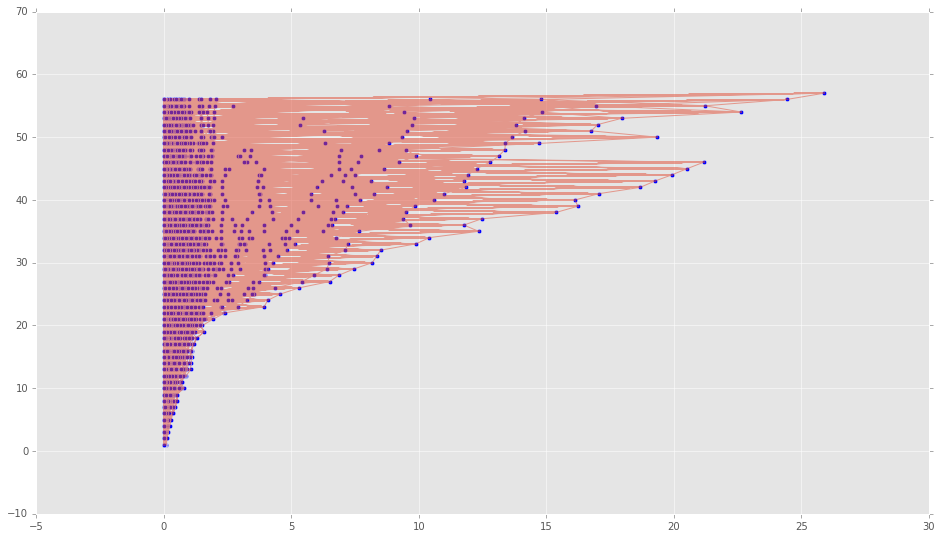

In [18]:
Xe_nan = [e if e is not None else np.nan for e in Xe]
Ye_in_t_nan = [e if e is not None else np.nan for e in Ye_in_t]

fig = plt.figure(figsize=(16, 9))
ax = plt.gca()

# Plot 
ax.plot(Xe, Ye, '-', alpha=0.5)
ax.scatter(Xh, Yh)

#py.iplot_mpl(plt.gcf())

# Load data of a halo

In [11]:
halo_i = 25661

In [14]:
# open the particles around halo
if os.path.isfile('data/halo_%s-00002_around.hdf5' % halo_i):
    print('Reading hdf5')
    df = pd.read_hdf('data/halo_%s-00002_around.hdf5' % halo_i, 'data')
else:
    print('Reading csv')
    df = pd.read_csv('data/halo_%s-00002_around'%halo_i, delim_whitespace=True, index_col=0, engine='c')
    #store it to hdf storage for further use
    df.to_hdf('data/halo_%s-00002_around.hdf5' % halo_i, 'data')

Reading hdf5


In [12]:
# open the particles in halo
if os.path.isfile('data/halo_%s-00002.hdf5' % halo_i):
    print('Reading hdf5')
    df_in = pd.read_hdf('data/halo_%s-00002.hdf5' % halo_i, 'data')
else:
    print('Reading csv')
    df_in = pd.read_csv('data/halo_%s-00002'%halo_i, delim_whitespace=True, index_col=0, engine='c')
    #store it to hdf storage for further use
    df_in.to_hdf('data/halo_%s-00002.hdf5' % halo_i, 'data')

Reading hdf5


# Some plots 

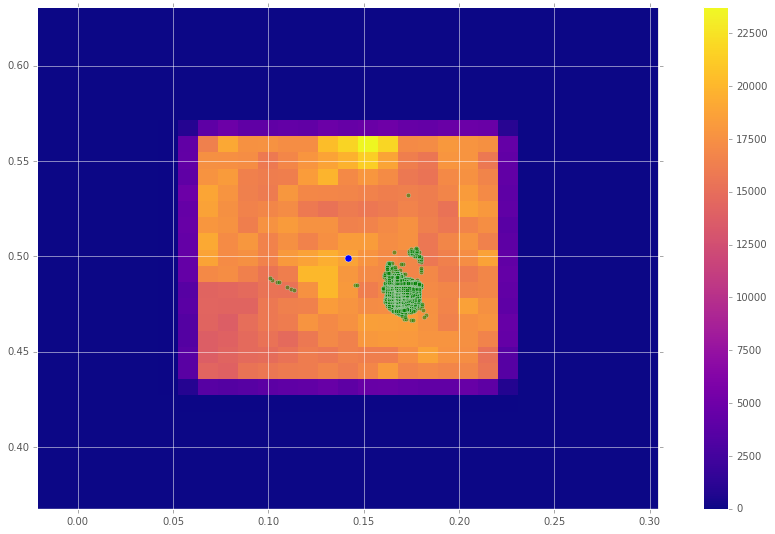

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')

around = (df_in[['x', 'y', 'z']].max() + df_in[['x', 'y', 'z']].min()) / 2
span   = df_in[['x', 'y', 'z']].max() - df_in[['x', 'y', 'z']].min()

f = 2
extent = [[around.x - f*span.x, around.x + f*span.x], [around.y - f*span.y, around.y + f*span.y]]

bins = 32
xe, ye = np.linspace(extent[0][0], extent[0][1], bins), np.linspace(extent[1][0], extent[1][1], bins)
h, _,_ = np.histogram2d(df.x, df.y, bins=[xe, ye])
im = plt.imshow(h.T, origin='lower', extent=np.array(extent).flatten(), interpolation='none', cmap='plasma')
plt.colorbar()

h, _,_ = np.histogram2d(df_in.x, df_in.y, bins=[xe, ye], )
#im = plt.imshow(h.T, origin='lower', extent=np.array(extent).flatten(), interpolation='none', cmap='viridis')
#plt.colorbar()

ax.set_xlim(extent[0])
ax.set_ylim(extent[1])
#ax.set_zlim(around.z - span.z, around.z + span.z)

#ax.scatter(df.x, df.y, c='grey', alpha=0.1)
ax.scatter(df_in.x, df_in.y, c='green', alpha=0.5)

ax.scatter(around.x, around.y, s=50)

In [111]:
%%cython 

cimport numpy as np
from scipy import signal
import numpy as np

cdef double multivar_gaussian(int i, int j, int k, double imean, double index_to_unit, double sigma):
    ''' Return the value of a 3d gaussian centered on center at index i,j,k
    parameters:
    -----------
    i, j, k: the indexes

    returns:
    --------
    the value of a 3d gaussian at point i, j, k'''
    
    cdef float sq_sum

    sq_sum = (((i - imean)*index_to_unit)**2 + ((j - imean)*index_to_unit)**2 + ((k - imean)*index_to_unit)**2)

    return 1./(np.sqrt(2*np.pi) * sigma)**3 * np.exp(-sq_sum / (2*sigma**2))

def getGaussian(np.ndarray[double, ndim=2] df_as_m, int bins=32, double sigma=5e-2):
    cdef np.ndarray gaussian
    cdef np.ndarray[double, ndim=1] center, mins, maxs
    cdef double index_to_unit, imean, span
    cdef int npts
    
    # get center
    center = np.mean(df_as_m, axis=0)
    
    # get maximum span
    maxs = np.max(df_as_m, axis=0)
    mins = np.min(df_as_m, axis=0)
    span = np.max(maxs - mins) / 2
    
    # generate gaussian at 4sigma
    index_to_unit = span / bins
    npts = int(4*sigma / index_to_unit)
    if npts < 16:
        npts = 16
        
    imean = npts / 2

    v_multivar_gaussian = np.vectorize(lambda i,j,k: multivar_gaussian(i,j,k,imean,index_to_unit,sigma))

    gaussian = np.fromfunction(v_multivar_gaussian, (npts, npts, npts))
    gaussian /= np.max(gaussian)
    
    return gaussian, center, span

cpdef object computeHist(np.ndarray[double, ndim=3] gaussian, np.ndarray[double, ndim=1] center, double span, 
                         np.ndarray[double, ndim=2] data, int bins=32):
    # compute the histogram
    cdef np.ndarray[double, ndim=1] ex, dy, dz
    cdef np.ndarray[double, ndim=3] hist
    
    ex = np.linspace(center[0] - span, center[0] + span, bins)
    ey = np.linspace(center[1] - span, center[1] + span, bins)
    ez = np.linspace(center[2] - span, center[2] + span, bins)

    hist, edges = np.histogramdd(data, bins=[ex, ey, ez])
    return hist, [ex, ey, ez]

cpdef np.ndarray[double, ndim=3] convolve(np.ndarray[double, ndim=3] hist, np.ndarray[double, ndim=3] gaussian):
    return signal.fftconvolve(hist, gaussian)

  0%|          | 0/3 [00:00<?, ?it/s]

(4101799, 3)


100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


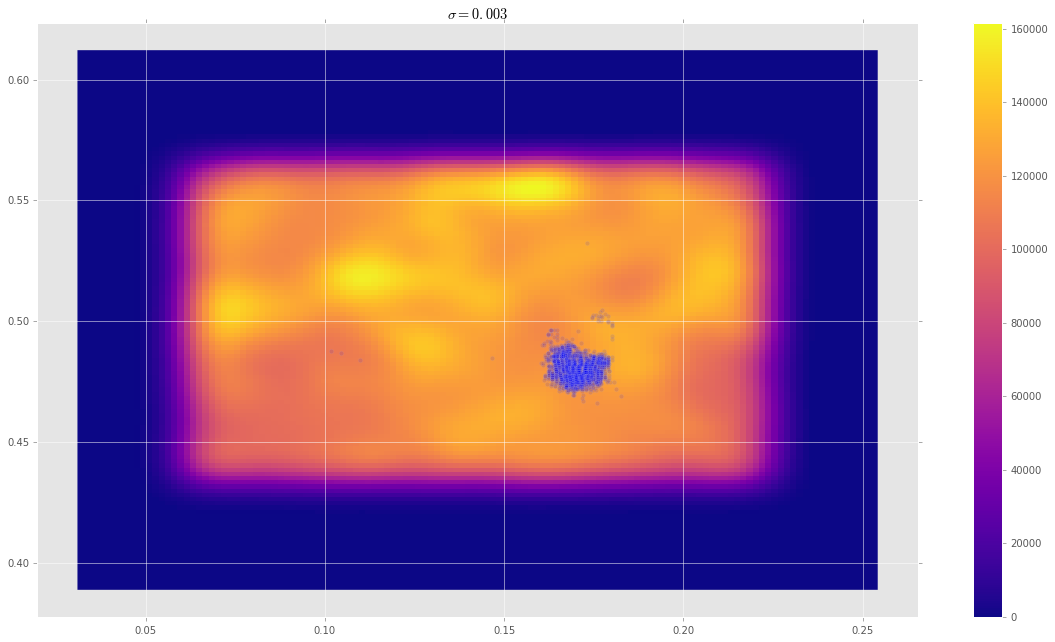

In [110]:
hist, edges = None, None
bins = 128

# select only region around halo
around = (df_in[['x', 'y', 'z']].max() + df_in[['x', 'y', 'z']].min()) / 2
span   = df_in[['x', 'y', 'z']].max() - df_in[['x', 'y', 'z']].min()

f = 2
mask = ((df.x < around.x + f*span.x) & (df.x > around.x - f*span.x) & 
        (df.y < around.y + f*span.y) & (df.y > around.y - f*span.y) &
        (df.z < around.z + f*span.z) & (df.z > around.z - f*span.z))

# cast the data frame into a numpy array
dfarr = df[mask][['x', 'y', 'z']].as_matrix()

n = 3
# adv = tqdm(enumerate([1e-4, 1e-3, 5e-3]))
adv = tqdm(enumerate(np.linspace(1e-5, 3e-3, n)), total=n)
for i, sigma in adv:
    # compute gaussian
    #adv.write('Compute gaussian')
    gaussian, center, span = getGaussian(dfarr, sigma=sigma, bins=bins)
    
    #adv.write('Compute hist')
    if hist is None:
        hist, (ex, ey, ez) = computeHist(gaussian, center, span, dfarr, bins=bins)
    
    #adv.write('Compute convolution')
    res = convolve(hist, gaussian)
    
    # recenter the image
    gs = gaussian.shape[0] // 2
    res2 = res[gs-1:-gs+1, gs-1:-gs+1, gs-1:-gs+1]

    #adv.write('Compute image')
    plt.clf()
    plt.imshow(np.sum(res2[:,:,bins//2-16:bins//2+16], axis=2).T,
               origin='lower', aspect='auto', interpolation='none', cmap='plasma',
              extent=[ex[0], ex[-1], ey[0], ey[-1]])
    plt.colorbar()
    
    # plot only 4000 elements
    each = max(1, df_in.index.size // 2000)
    
    plt.scatter(df_in.x[::each], df_in.y[::each], alpha=0.1)
    
    plt.title('$\sigma = %s$' % sigma)
    plt.tight_layout()
    if not os.path.isdir('/home/cadiou/tmp/smooth_plots/{0}'.format(halo_i)):
        os.mkdir('/home/cadiou/tmp/smooth_plots/{0}'.format(halo_i))

    plt.savefig('/home/cadiou/tmp/smooth_plots/{0}/halo_{0}_{1:0>5}_sigma_from_e-5_to_e-2.pdf'.format(halo_i, i))
adv.close()

In [119]:
df.to_hdf('tmp/25661.positions.hdf', 'all')

In [104]:
adv.close()

# Tests with own module

Convolve our data with the gaussian

In [13]:
# size of the filter
bins = 64

In [14]:
# zoom around region
around = (df_in[['x', 'y', 'z']].max() + df_in[['x', 'y', 'z']].min()) / 2
span   = df_in[['x', 'y', 'z']].max() - df_in[['x', 'y', 'z']].min()
mean = df_in[['x', 'y', 'z']].mean()
std = np.max((df_in[['x', 'y', 'z']] - mean).std())

f = 20
#mask = ((df.x < around.x + f*span.x) & (df.x > around.x - f*span.x) & 
#        (df.y < around.y + f*span.y) & (df.y > around.y - f*span.y) &
#        (df.z < around.z + f*span.z) & (df.z > around.z - f*span.z))

In [15]:
%%skip
mask = ((df.x < mean.x + f*std) & (df.x > mean.x - f*std) & 
        (df.y < mean.y + f*std) & (df.y > mean.y - f*std) &
        (df.z < mean.z + f*std) & (df.z > mean.z - f*std))

dfzoomed = pd.DataFrame(df[mask])

ERROR: Cell magic `%%skip` not found.


In [16]:
dfzoomed = pd.read_hdf('tmp/dfzoomed')

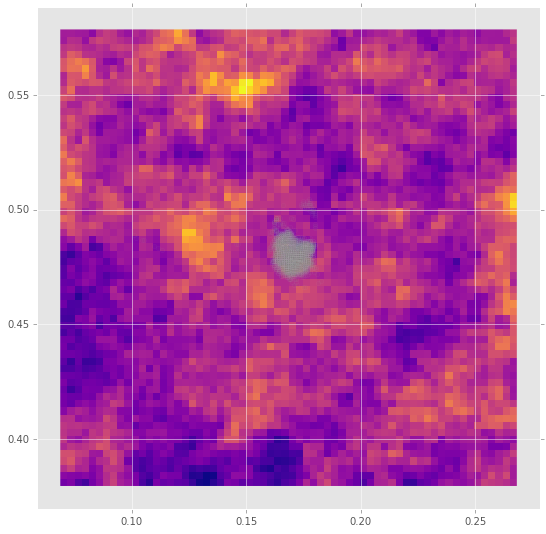

In [17]:
hist, edges = convolution.convolution.conv_hist3d(dfzoomed[['x' ,'y', 'z']].as_matrix().T, bins)
plt.imshow(np.sum(hist, axis=2).T, extent=(edges[0][0], edges[0][-1], edges[1][0], edges[1][-1]), interpolation='none', origin='lower',
           cmap='plasma')
plt.scatter(df_in.x, df_in.y, alpha=0.05, c='grey')

In [18]:
%%time
gaussian = convolution.convolution.kernel_gaussian3d(bins, 1)
gfft = convolution.convolution.fft(gaussian)
gaussian.shape

CPU times: user 37 ms, sys: 6 ms, total: 43 ms
Wall time: 42.5 ms


In [19]:
%%time
hfft = convolution.convolution.fft(hist)
gfft = convolution.convolution.fft(gaussian)

cfft = convolution.convolution.conv_prod(hfft, gfft)

conv = convolution.convolution.ifft(cfft)

CPU times: user 50 ms, sys: 7 ms, total: 57 ms
Wall time: 56.4 ms


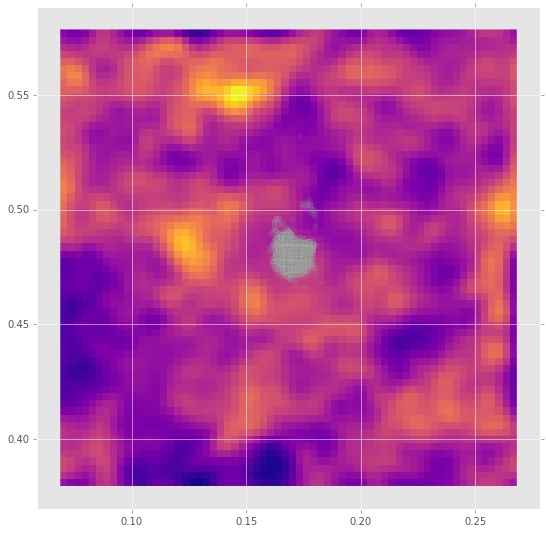

In [20]:
plt.imshow(np.sum(conv, axis=2).T, interpolation='none', extent=(edges[0][0], edges[0][-1], edges[1][0], edges[1][-1]),
           origin='lower', cmap='plasma')
plt.scatter(df_in.x, df_in.y, alpha=0.1, c='grey')

In [26]:
%%time
hfft = np.fft.rfftn(hist)
gfft = np.fft.rfftn(gaussian)

cfft = hfft * gfft

'''cfft2 = np.zeros_like(cfft)

for i, j, k in itertools.product(range(cfft.shape[0]), range(cfft.shape[1]), range(cfft.shape[2])):
    cfft2[i, j, k] = cfft[i, j, k] * (-1)**(i + j + k)'''
conv = np.fft.irfftn(cfft)

CPU times: user 59 ms, sys: 7 ms, total: 66 ms
Wall time: 64.1 ms


In [1]:
plt.imshow(np.sum(conv, axis=2).T, interpolation='none', extent=(edges[0][0], edges[0][-1], edges[1][0], edges[1][-1]),
           origin='lower', cmap='plasma')
plt.scatter(df_in.x, df_in.y, alpha=0.1, c='grey')

NameError: name 'conv' is not defined

### And now, ducks

In [ ]:
merge = GO.Scattergl(x=Xe, y=Ye_in_t, mode='lines', name='fusion', line=dict(width=0.5))
halos = GO.Scattergl(x=Xh, y=Yh_in_t, mode='markers', name='halos',
                opacity=0.1)
data = GO.Data([merge, halos])
layout = GO.Layout(
    xaxis= dict(title='Mass'),
    yaxis= dict(title='Lookback time [Gyr]'),
    #width=16,
    #height=9    
)

fig = GO.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
steps = range(rt.nsteps-1, rt.nsteps-step_n-1, -1,)
rt.age_univ[steps]

In [ ]:
plt.figure(figsize=(23, 16))
plt.plot(rt.age_univ, '-o')
plt.xlabel('Step')
plt.ylabel('Time (Gyr)')

In [ ]:
plt.figure(figsize=(23, 16))
plt.plot(rt.aexp, 'o-')
plt.xlabel('Step')
plt.ylabel('Expansion factor')

In [ ]:
plt.figure(figsize=(23, 16))
plt.plot(1/rt.aexp - 1, 'o-')
plt.xlabel('Step')
plt.ylabel('Redhift')
plt.yscale('log')